In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# jt -t monokai -N -T -kl -nfs 10 -tfs 10 -cellw 80%
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

In [2]:
#export
from exp.nb_04 import *

## Initial setup

In [3]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [6]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.6763653125, tensor(0.7990)]
valid: [0.310048779296875, tensor(0.9100)]
train: [0.29883419921875, tensor(0.9140)]
valid: [0.2395763671875, tensor(0.9313)]
train: [0.23947705078125, tensor(0.9317)]
valid: [0.21986962890625, tensor(0.9349)]


In [7]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data) #maybe change the default lr
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.7665371875, tensor(0.7985)]
valid: [0.3436525146484375, tensor(0.9059)]
train: [0.3460759765625, tensor(0.9016)]
valid: [0.28538291015625, tensor(0.9209)]
train: [0.2974948046875, tensor(0.9139)]
valid: [0.259881689453125, tensor(0.9262)]


In [8]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

In [9]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[] # at the start of training init the lr and loss lists

    def after_batch(self):
        if not self.in_train: return                      # do nothing if not training
        self.lrs.append(self.opt.param_groups[-1]['lr'])  # otherwise append current lr and loss
        self.losses.append(self.loss.detach().cpu())      # notice we get the lr for the last param_group
                                                          # which is like the last layer (see below)
            #  info on param_groups 
            # https://pytorch.org/docs/stable/optim.html            
            # https://discuss.pytorch.org/t/a-problem-about-optimizer-param-groups-in-step-function/14463
            # https://stackoverflow.com/questions/51756913/in-pytorch-how-do-you-use-add-param-group-with-a-optimizer

    def plot_lr  (self): plt.plot(self.lrs)               # methods to plot what's recorded
    def plot_loss(self): plt.plot(self.losses)

# This is a general callback that schedule SOMETHING (could be lr, could be any other hyperparameter) 
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func
    # it takes a parameter name (the object to be scheduled) and a scheduler function that, 
    # depeding on WHERE (pos) we are in the training process, will change the par value

    def begin_batch(self): # at the beginning of every batch
        if self.in_train:
            for pg in self.opt.param_groups: # go through all param_groups (is a dict) and search for params with the name 'self.pname'
                pg[self.pname] = self.sched_func(self.n_epochs/self.epochs) # all those found get modified based on scheduling function and pos
                # recall that self.n_epochs is a float, so self.n_epochs/self.epochs returns a float between 0 and 1

Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion.

In [10]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

We can refactor this with a decorator.

In [11]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

Decorators essentially take the function define below them as a parameter (so `sched_lin` gets passed into `f`) and the `annealer` decorator in particular defines a function `_inner` that is a partial of `sched_lin(start, end, pos)` with binded `start,end` and substitutes it to the original function.

This means that now `scehd_lin` is a function that takes `start,end` and return a function that is equivalent to `partial(scehd_lin, start, end)`, that takes only `pos` as argument.

In [12]:
# shift-tab works too, in Jupyter!
# sched_lin()

In [13]:
f = sched_lin(1,2)
f(0.3)

1.3

And here are other scheduler functions:

In [14]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

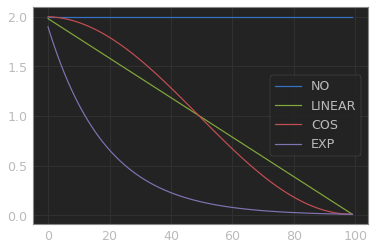

In [15]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In practice, we'll often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In [16]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1. # check that we cover all the phases of pos
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0) # check that they're all positive
    pcts = torch.cumsum(pcts, 0) # computes their cumsum
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner
    # returns a function(it's important, doesn't return a value nor does the scehduling 
    #      it's going to be returned_function(pos) that does the scehduling)
    # that checks where are we in the training, get the correct scheduler (idx) and 
    # computes where we are WITHIN ITS RANGE. This function then will be called with `pos` and will schedule.

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [17]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

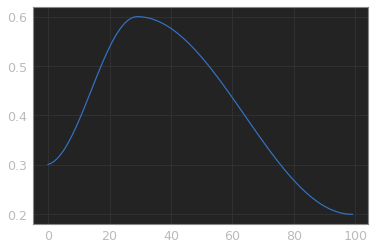

In [18]:
plt.plot(a, [sched(o) for o in p])

We can use it for training quite easily...

In [19]:
# list of callbacks
cbfs = [Recorder, # we wanna see the recorder so that we can keep track of lr and losses
        partial(AvgStatsCallback,accuracy), # let's use this callback that prints useful info as the training goes on
        partial(ParamScheduler, 'lr', sched)] # and let's use the combined scheduler
                                              # scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])
                                              # to schedule the lr as we go in training (one_cycle scehduler) 

In [20]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [21]:
run.fit(3, learn)

train: [0.791471953125, tensor(0.7813)]
valid: [0.3274529296875, tensor(0.9027)]
train: [0.3051411328125, tensor(0.9103)]
valid: [0.241627587890625, tensor(0.9318)]
train: [0.245641328125, tensor(0.9300)]
valid: [0.218724853515625, tensor(0.9408)]


... then check with our recorder if the learning rate followed the right schedule.

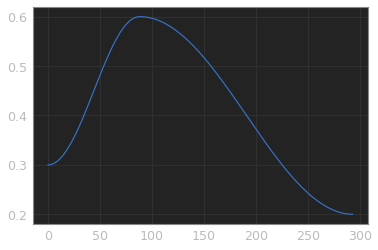

In [22]:
run.recorder.plot_lr()

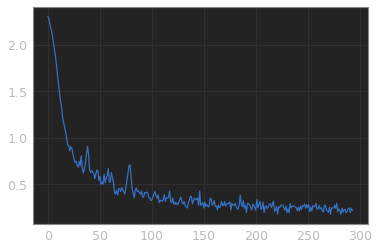

In [23]:
run.recorder.plot_loss() # let's use the recorder to see the losses as we trainedas well.

In [24]:
#export
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

## Export

In [1]:
!python3 notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to exp/nb_05.py


Note the above is only one part of the `one_cycle` policy, as an (essentially) inverse scheduler is used for momentum in the `one_cycle` schedule!